In [1]:
%pylab inline

import pandas as pd
%load_ext autoreload
%autoreload 2
import pysfg

Populating the interactive namespace from numpy and matplotlib


# Static Spectra Analysis

## Quartz or Gold Spectrum for Normalization

The idea of the analysis is to separate some distinct properties of the data analysis. The `static_spectra.py` script contains the typical logic of what one want to do with static spectral data. For each use case, a new `some_name.yaml` file needs to be passed to the `static_spectra.py` script, configuring a specific set of data. What basically happens is:  

- read of data files
- calibrate pixels to wavenumbers 
- trim data (pixels and spectrum index)
- take median of scans and pp_delays
- save result in a structured `.json` file

The syntax for using `static_spectra.py` is:

```
python static_spectra.py path_to_config.yaml
```

or from within the notebook:
```
%run static_spectra.py path_to_config.yaml
```


`yaml` files are a structured way of storing information or in this case configuration. [Here](https://rollout.io/blog/yaml-tutorial-everything-you-need-get-started/) is a possible tutorial explaining many aspects of yaml. Understanding yaml is not very difficult. If you are confused by `simple_gold.yaml` take a peak at the mentioned tutorial. In short, indentation matters, `:` separates `key:value` just like python dictionaries, lists can be given with`[1, 2, 3]`  or

``` yaml
- 1
- 2
- 3 
```

numbers are read as `float` or `int`, text is read as `string`

Lets go through the structure of `simple_gold.yaml` for now:

``` yaml
calibration:
    vis_wl: 799.7 # Wavelength of the visible
    calib_central_wl: 680 # central wavelength during calibration
    calib_coeff: [0.080881, 615.18] # calibration coefficients from calibration
```

This block shows how to apply a calibration. This `calibration:` block is read by the `static_spectra.py` script and used for calibration. If it doesn't exist, `static_spectra.py` tries to read the information of the data file. Take a look at `static_spectra.py` within you find the following block:

``` python
    calibration_config = config.get('calibration', {})
    calibration = pysfg.Calibration(
        calibration_config.get('central_wl', intensity_data['central_wl']),
        calibration_config.get('vis_wl', intensity_data['vis_wl']),
        calibration_config.get('calib_central_wl', intensity_data['calib_central_wl']),
        calibration_config.get('calib_coeff', intensity_data['calib_coeff'])
    )
```
This block is mostly responsible for the above behaviour. `config` is the python respresentation of the complete `simple_gold.yaml` file. Within `config` a `calibration` key is searched and if not found, and empty dict is passed. Then within the `calibration` dict, `central_wl`, `vis_wl`, `calib_central_wl` and `calib_coeff` is used and if not found the infomration is read of the `intensity_data` dict, that represents the content of the `intensity_data` file, including the header.

This calibration is then followed by a `data:` block. This block is mandatory and it consists out of an arbitrary amount of `-` separated blocks. Each of these blocks is configuring a single spectrum by referencing it to its respective `intensity_data:`, `baseline_data:` and `norm_data:`. However only the `intensity_data:` and `name:` is mandatory. The rest is optional.
   
``` yaml
data:
  -
    # Path to a data file that contains raw intensity data.
    intensity_data:  "../tests/data/gold.dat"
    # Configure selection of data. E.g. pixels, pp_delays, spectra or scans.
    intensity_selector:
      # The index of the spectrum that should be used.
      spectra: 1
    # Path to a data file that contains raw background data.
    background_data: "../tests/data/gold_bg.dat"
    background_selector:
      spectra: 1
      #pixel: Has no function here, as it is overwritten by the intensity_selector pixels.
    name: "cache/gold_1.json"
```

The key `intensity_data` is mapped to a file path with a `.dat` data file and the path is relative to the position of this notebook you are looking at right now. The `intensity_selector` is optional and can have up to four sub keys: `pp_delays`, `scans`, `spectra` and `pixel`. For static spectra `spectra` and `pixel` are the most important.  As they are used to trim down the data onto a relevant subset. `spectra: 1` means take only spectrum 1. Internally a `pysfg.SelectorPP` object is created from this block. The `background_data`  and `background_selector` then works identical but is taking care of the background intensity. `name` is the path to a `.json` file, where the structured result of the `static_spectra.py` script is saved as a `json` file. This file can then be used for visualizing and further processing of the spectrum. For educational purpose the full data block is:


```yaml
data:
  -
    # Path to a data file that contains raw intensity data.
    intensity_data:  "../tests/data/gold.dat"
    # Configure selection of data. E.g. pixels, pp_delays, spectra or scans.
    intensity_selector:
      # The index of the spectrum that should be used.
      spectra: 1
    # Path to a data file that contains raw background data.
    background_data: "../tests/data/gold_bg.dat"
    background_selector:
      spectra: 1
      #pixel: Has no function here, as it is Overwritten by the intensity_selector pixels.
    # name is where the result of the calibration should be saved.
    name: "cache/gold_1.json"
  # You can have as many of these blocks separated with - as you want
  -
    intensity_data:  "../tests/data/gold.dat"
    intensity_selector:
      spectra: 0 # Lets use some other spectrum of the same data file
      pixel: [520, 810] # A list in [start, stop, step] order
      scans: [0, 3] # use only the first three scans.
      pp_delays: null # This is the same as not putting it at all
    background_data: "../tests/data/gold_bg.dat"
    background_selector:
      spectra: 0
    name: "cache/gold_2.json"

```
Where a second `-` block is added. It shows some more possible options and how this script can be used to process arbitrary amount of spectra. Just append another `-` block and configure it to your liking. 

Now lets see how to actually run this. Execute:

In [2]:
%run static_spectra.py simple_gold.yaml

INFO:root:Importing: ../tests/data/gold.dat
INFO:root:Using data_select is:
[slice(None, None, None), slice(None, None, None), 1, slice(None, None, None)]
INFO:root:Using Calibration with:
Central Wavelength: 680.0
Visible Wavelength: 799.7
Calibration Coefficients: (0.080881, 615.18)
Calibration Central Wavelength: 680.0

INFO:root:Save as: cache/gold_1.json
INFO:root:Importing: ../tests/data/gold.dat
INFO:root:Using data_select is:
[slice(None, None, None), slice(0, 3, None), 0, slice(520, 810, None)]
INFO:root:Using Calibration with:
Central Wavelength: 680.0
Visible Wavelength: 799.7
Calibration Coefficients: (0.080881, 615.18)
Calibration Central Wavelength: 680.0

INFO:root:Save as: cache/gold_2.json


The log above gives you some information on what is happening. It tells you the path of the imported data, the calibration configuration and the path where the result is exported.

Next step is to visualize the result. The following is a possible example of what you could do now:

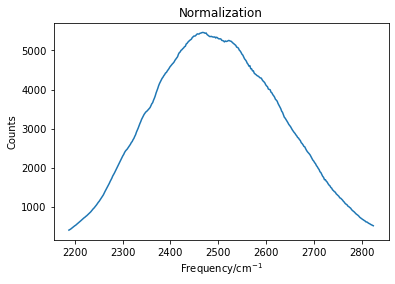

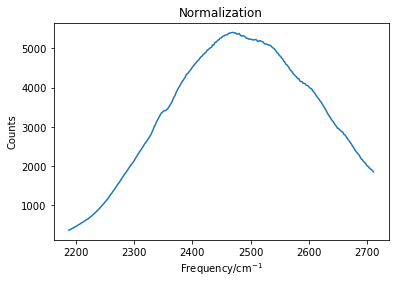

In [4]:
# Import the json files and create a pysfg.Spectrum object from them in one go.
norm = pysfg.spectrum.json_to_spectrum('cache/gold_1.json')
norm2 = pysfg.spectrum.json_to_spectrum('cache/gold_2.json')

# Select some pixels for visualization
pixel=[460, 810]
# Figures
fig, ax = plt.subplots()
plt.plot(norm.wavenumber[slice(*pixel)], norm.basesubed[slice(*pixel)])
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('Counts')
plt.title('Normalization')

# Figures
fig, ax = plt.subplots()
plt.plot(norm2.wavenumber, norm2.basesubed)
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('Counts')
plt.title('Normalization');

In the example above, the calibration is manually passed within the `simple_gold.yaml` file in the `calibration:` section. This is needed, because the read file `../tests/data/gold.dat` contains no correct calibration data. Just open the file and check out the `# calib Coeff=0` line. This is not a correct calibration. The file `../tests/data/sc_quartz.dat` contains a correct calibration. Checkout the file header. It reads: `# calib Coeff=670	642.101	0.034274	0	0	0	0` 

`simple_quartz.yaml` shows you a configuration that reads the information of the file itself.

In [5]:
%run static_spectra.py simple_quartz.yaml

INFO:root:Importing: ../tests/data/sc_quartz.dat
INFO:root:Using data_select is:
[slice(None, None, None), slice(None, None, None), 0, slice(None, None, None)]
INFO:root:Using Calibration with:
Central Wavelength: 674.0
Visible Wavelength: 811.7
Calibration Coefficients: (0.034274, 642.101)
Calibration Central Wavelength: 670.0

INFO:root:Save as: cache/quartz_1.json


<Figure size 432x288 with 0 Axes>

Again import and visualize

Text(0.5, 1.0, 'Normalization')

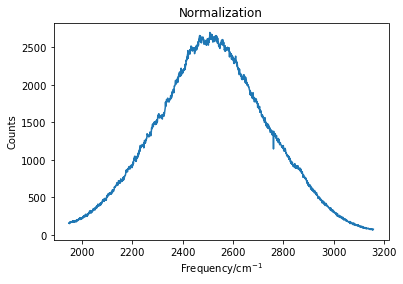

In [6]:
norm = pysfg.spectrum.json_to_spectrum('cache/quartz_1.json')
pixel=slice(None)

# Figures
fig, ax = plt.subplots()
plt.plot(norm.wavenumber[pixel], norm.basesubed[pixel])
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('Counts')
plt.title('Normalization')

I highly encourage you to use this import/export scheme as you see here. Initially it is some overhead, but in time you will realize, that it separates logic (analysis) from plotting (visualizing) and it will make your live way easier if you start preparing presentations, or papers or what ever, you want to be able to quickly change the visualization but not the logic. This scheme allows you to do so.

## Normalize a Static Spectrum

To normalize some static spectra, you can use the same template script `static_spectra.py`. However you have to change the specific configuration of course.

In [7]:
%run static_spectra.py simple_spectrum.yaml

INFO:root:Importing: ../tests/data/sc_d2o-dopc.dat
INFO:root:Using data_select is:
[slice(None, None, None), slice(None, None, None), 1, slice(200, 1200, None)]
INFO:root:Using Calibration with:
Central Wavelength: 674.0
Visible Wavelength: 811.7
Calibration Coefficients: (0.034274, 642.101)
Calibration Central Wavelength: 670.0

INFO:root:Save as: cache/sc_d2o-dopc_static.json


<Figure size 432x288 with 0 Axes>

Now `simple_spectrum.yaml` contains:
    
```yaml
data:
  -
    intensity_data:  "../tests/data/sc_d2o-dopc.dat"
    intensity_selector:
      spectra: 1
      # you can pass all kwargs of pysfg.SelectorPP here. Thus also:
      pixel: [200, 1200]
      # scans: [start, stop, step]
      # pp_delays: [start, stop, step]
    background_data: "../tests/data/bg_d2o-docpe.dat"
    background_selector:
      spectra: 1
    # Norm data must be the result of a prior static_spectra.py run.
    norm_data: "./cache/quartz_1.json"
    name: "cache/sc_d2o-dopc_static.json"
```

Basically everything is identical to the quartz or gold case as we have seen above, but note the `norm_data` line. Here we give it a path to one of the previously exported `quartz_1.json` files, as we want to use this for normalization. There is no `norm_selector` keyword available, if you want to change the normalization, go to the `simple_quarty.yaml` file, add or change one of the blocks in `data:` and reference the result here.

Now lets visualize the result:

Text(0.5, 1.0, 'Baseline Subtracted')

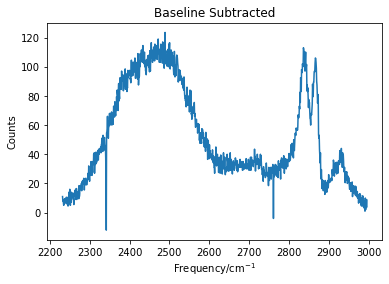

In [10]:
sc = pysfg.spectrum.json_to_spectrum('cache/sc_d2o-dopc_static.json')

# Figures
fig, ax = plt.subplots()
plt.plot(sc.wavenumber, sc.basesubed)
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('Counts')
plt.title('Baseline Subtracted')

Or if you want to plot the normalized version you do:

Text(0.5, 1.0, 'Normalized')

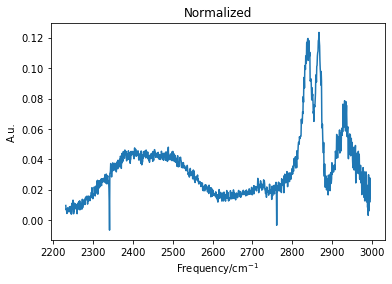

In [11]:
fig, ax = plt.subplots()
plt.plot(sc.wavenumber, sc.normalized)
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('A.u.')
plt.title('Normalized')

Or you can even take a look at the raw data:

Text(0.5, 1.0, 'Raw Data')

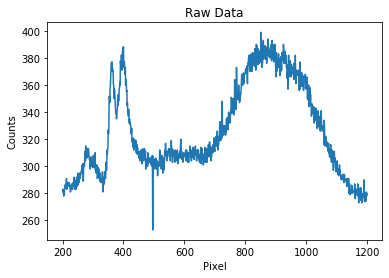

In [12]:
fig, ax = plt.subplots()
plt.plot(sc.pixel, sc.intensity)
plt.xlabel('Pixel')
plt.ylabel('Counts')
plt.title('Raw Data')

Note how the pixels start at 200 and not at 0, as we have configured it that way in `simple_spectrum.yaml` by passing it `pixel: [200, 1200]`. If you want, you can also create a pandas Dataframe from the result of `simple_spectrum.py` Just do the following:

In [13]:
pd.read_json('./cache/sc_d2o-dopc_static.json')

,intensity,baseline,norm,wavenumber,pixel,intensityE
0,282,278.0,331,2995.15,200,1.452966
1,281,272.0,325,2994.35,201,1.201850
2,283,278.0,318,2993.54,202,3.844188
3,280,276.0,331,2992.74,203,0.666667
4,278,276.0,338,2991.93,204,1.666667
...,...,...,...,...,...,...
995,274,269.0,1170,2234.98,1195,1.527525
996,275,268.0,1185,2234.25,1196,2.603417
997,281,272.5,1171,2233.53,1197,2.000000
998,278,270.0,1180,2232.80,1198,0.333333


# Time Series Data

Analysing pump probe data is more challenging then static data. The overall process involves multiple steps:
- Background subtraction
- Normalization
- Data selection (pixels, spectra and scans)
- Averaging of scans
- Filtering (e.g. gaussian filter
- Bleach calculation (difference or ratio)
- Stability investigation
- Cross correlation
- Pump position
- Pump leakage
- Trace calculation
- Trace fitting
- 2D plot generation

These are too many requirements for one script. Instead I try to separate this into multiple scripts.

`timescan.py` deals with:
- Background subtraction
- Normalization
- Data selection (pixels, spectra and scans)
- Averaging of scans
- Filtering (e.g. gaussian filter

The result of the `timescan.py` script can then be used to:
- Calculate bleach
- Visualize Cross Correlation
- Visualize Pump position or leakage

`bleach.py` is used for bleach calculation it allows to:
- Define relative (ratio) or absolute (difference) bleach
- Correct for static offset between pumped and probed
- Heat correction of bleach

`trace.py` takes the output of `bleach.py` and produces traces. 

With `fit_traces.py` the output of `traces.py` can be fitted.

With the `timescan.py` script we do the basic work of background subtraction, normalization, averaging and so on. It is very similar to `static_spectra.py` only that is for pump-probe data and will not average over the pump-probe delay axis. Additionally there is the:

```yaml
    intensity_filter:
      gaussian_filter1d:
        sigma: 5
```
block, that allows to use a gaussian filter on the data. And possibly in the futer even other filters.

In [28]:
%run timescan.py timescan.yaml

INFO:root:Importing: ../tests/data/dynamic_test_data.dat
INFO:root:Using data_select is:
[slice(None, None, None), slice(None, None, None), 0, slice(520, 810, None)]
INFO:root:Using Calibration with:
Central Wavelength: 680.0
Visible Wavelength: 799.7
Calibration Coefficients: (0.080881, 615.18)
Calibration Central Wavelength: 680.0

INFO:root:Saving to: ./cache/pumped.json
INFO:root:Importing: ../tests/data/dynamic_test_data.dat
INFO:root:Using data_select is:
[slice(None, None, None), slice(None, None, None), 1, slice(520, 810, None)]
INFO:root:Using Calibration with:
Central Wavelength: 680.0
Visible Wavelength: 799.7
Calibration Coefficients: (0.080881, 615.18)
Calibration Central Wavelength: 680.0

INFO:root:Saving to: ./cache/probed.json


<Figure size 432x288 with 0 Axes>

In [29]:
# Import the pumped and probed data with baseline subtraction 
pumped = pysfg.spectrum.json_to_pumpprobe('./cache/pumped.json')
probed = pysfg.spectrum.json_to_pumpprobe('./cache/probed.json')

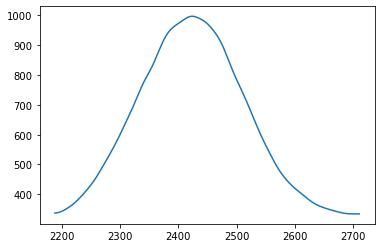

In [33]:
# Just to check that this is working we make a little plot
fig, ax = plt.subplots()
plt.plot(pumped.wavenumber, pumped.intensity[2])
plt.show()


The bleach is what we are after. `bleach.py` takes care of making bleach data.

In [80]:
%run bleach.py bleach.yaml

INFO:root:Run difference mode
INFO:root:Running static difference correction
INFO:root:Running heat correction with: {'tau': 700, 'c': 0}
INFO:root:Saving to: ./cache/bleach.json
INFO:root:Run ratio mode
INFO:root:Running static difference correction
INFO:root:Running heat correction with: {'tau': 700, 'c': 0}
INFO:root:Saving to: ./cache/bleach1.json


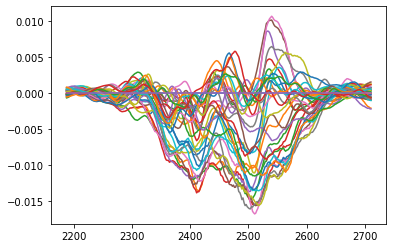

In [83]:
bleach = pysfg.spectrum.json_to_bleach('./cache/bleach.json')

fig, ax = plt.subplots()
plt.plot(bleach.wavenumber, bleach.normalized.T)
plt.show()

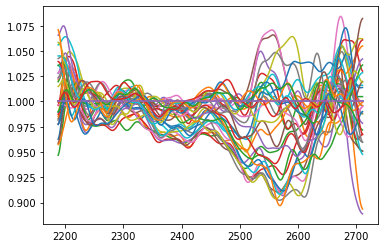

In [84]:
bleach = pysfg.spectrum.json_to_bleach('./cache/bleach1.json')

fig, ax = plt.subplots()
plt.plot(bleach.wavenumber, bleach.normalized.T)
plt.show()

Or you can make a 2D Plot here

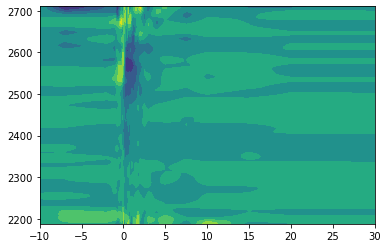

In [105]:
fig, ax = plt.subplots()
plt.contourf(bleach.pp_delay/1000, bleach.wavenumber, bleach.normalized.T)

In [ ]:
bleach.normalized.shape

Lets make some traces out of this

In [110]:
%run trace.py trace.yaml

INFO:root:Saving to: ./cache/hf.json
INFO:root:Saving to: ./cache/lf.json


And visualize the data

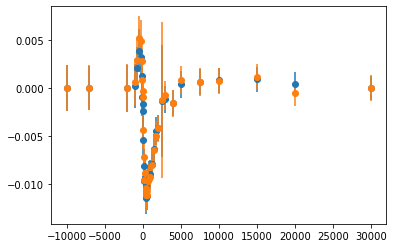

In [111]:
hf = pysfg.json_to_trace('./cache/hf.json')
lf = pysfg.json_to_trace('./cache/lf.json')

fig, ax = plt.subplots()
plt.errorbar(hf.pp_delay, hf.bleach, hf.bleachE, fmt='o')
plt.errorbar(lf.pp_delay, lf.bleach, lf.bleachE, fmt='o');

The next step is to fit the traces. This we do with 

In [115]:
lf.pp_delay.shape, lf.bleach.shape

((35,), (35,))

In [119]:
%run fit_trace.py fit_trace.yaml

------------------------------------------------------------------
| FCN = 7.155                   |     Ncalls=539 (539 total)     |
| EDM = 2.22e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | Amp    |    42m    |    4m     |            |            |         |         |       |
| 1 | t1     |    1.9    |    0.4    |            |            |         |         |       |
| 2 | t2     |   700m    |    7m     |            |            |         |         |  yes  |
| 3 | c      |   0.85    |   0.15    |            |            |         |         |       |
| 4 | mu     |   0.099   |   0.029   |            |            |         |         |       |
| 5 | sigma  |  150.0m   |   1.5m    |            |            |         |         |  yes  |
| 6 | offset |  -0.976   |   0.010   |            |            |         |         |       |
--------------------------------------------------------------------------------------------